# Influence of antecedent precipitation through the critical zone and across spatial scales

# Introduction



# Research question and hypotheses
How does antecedent precipitation drive the export of deep v. shallow-sourced critical zone analytes

# Study site


# Data sets


In [2]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

In [3]:
# Parameters
infile27 = 'usgs_raymond_2013.txt'
infile72 = 'usgs_newmarket_2013.txt'

drainage_area27 = 144.3
drainage_area72 = 476.9

infile_p = 'thompsonppt.csv'

grab_input = '20251001 Lamprey Weekly Monthly QAQC w formatting.xlsx'

info = 'sites.txt'


In [4]:
# Generate site list
with open(info, "r") as sitenames:
	sites = sitenames.readlines()
    
sites = sites[0]
sites=sites.split(',')

In [5]:
# Function to read and clean discharge data
CFS_TO_MM_DAY = (1/5280)**2 * 304.8 * 86400

def read_usgs(datafile, drainage_area):
    """Read in usgs discharge .csv as dataframe, set date as index, define missing 
    values, convert discharge from CFS to mm/day.

    Parameters
    ----------
    datafile : str
        Input data file
    drainage_area : int
        Drainage area in sq miles. Pulled from input_data
        
    Returns
    ----------
    data : DataFrame
        Read and cleaned dataframe

    """

    # Load discharge data from file and set date as index
    data = pd.read_csv(datafile, delimiter = '\t', comment = '#', index_col = ['datetime'])

    # Drop irrelevant columns and rows
    colnames_tokeep = []
    for col in data.columns.tolist():
        if '00060' in col and 'cd' not in col:
            colnames_tokeep.append(col)
        
    data = data[colnames_tokeep]

    data = data.iloc[1:,]

    data.index = pd.to_datetime(data.index)

    data.rename(columns={data.columns[0]: 'Q_CFS'}, inplace=True)
    data['Q_CFS'] = pd.to_numeric(data['Q_CFS'], errors='coerce')


    # Rename discharge columns and drop irrelevant columns
    data.replace([9999,'NaN',-9999,'Ice','Bkw','Mnt'], np.nan , inplace = True)

    # Convert discharge data from cubic feet per second to millimeters per day
    data['runoff_MM'] = data['Q_CFS']/drainage_area * CFS_TO_MM_DAY
    
    return data


In [6]:
# Function to read and clean precipitation data
IN_TO_MM = 25.4

def read_ppt(filename):
    """ Read in precipitation csv as dataframe, set missing values to 0,
    add MDPR and PRCP columns, delete unnesecessary columns, and convert
    PRCP units from inches to millimeters
    
    Parameters
    ----------
    data : str
        Input data file
    
    Returns
    ----------
    data : dataframe that has been cleaned and PRCP units converted
    """
    
    # Load precipitation data from file and set date as index
    data = pd.read_csv(filename, 
                         parse_dates=['DATE'], index_col=['DATE'])
    
    # Set missing values to 0
    data.replace([9999,'NaN',-9999], 0 , inplace = True)

    # Add MDPR to PRCP column if present
    if 'MDPR' in data.columns:
        data['PRCP'] = np.nansum(data[['PRCP', 'MDPR']].values, axis=1)
        data.drop(columns='MDPR', inplace=True)
    else:
            data['PRCP'] = data['PRCP']
    
    # Convert precipitation data from inches to millimeters per day
    data['PRCP_MM'] = data['PRCP'] * IN_TO_MM
    
    # Delete unnecessary columns
    data.drop(columns = {"STATION","NAME","SNOW","SNWD","DAPR","MDSF","DASF","PRCP"}, errors = "ignore", inplace = True)

    return data

In [7]:
# Function to read in grab sample data

def wrangle(datafile, sites):
    """"
    Read in excel file of Lamprey data, set collection date as index and remove measurements without GHG
    data
    
    Parameters
    ----------
    datafile : string
        Name of filename to be read in
        
    Returns
    ---------
    data : DataFrame
        Wrangled data frame
    """
    

    data = pd.read_excel(datafile,
                           parse_dates=['Collection Date'], index_col='Collection Date')
    
    # Remove sites that aren't in site list
    data = data[data['Sample Name'].isin(sites)]
    
    # Loop through columns to remove rows with GHG data 
    for col in data.columns.tolist():
        if col.startswith('CH4') or col.startswith('CO2') or col.startswith('N2O'):
            data.dropna(subset = col, inplace = True)
    
    # sort df by index
    data.sort_index(inplace=True)
    
    return data


In [8]:
# Read in and clean data sets

# Discharge
data27 = read_usgs(infile27, drainage_area27)
data72 = read_usgs(infile72, drainage_area72)

data27['DOY'] = data27.index.dayofyear
data72['DOY'] = data72.index.dayofyear

# Precipitation
data_p = read_ppt(infile_p)
data_p['DOY'] = data_p.index.dayofyear

# Grab samples
grab_data = wrangle(grab_input, sites)  

In [9]:
# Merge dataframes for CQ

## New dataframe of LMP 27 weekly paired with matching discharge
merged_27 = pd.merge(grab_data.loc[grab_data['Sample Name'] == 'LMP27'], 
                     data27,left_index=True, right_index=True, how='left')

# Merge with precip
merged_27 = pd.merge(merged_27, data_p, left_index = True, right_index = True, how = "left")
merged_27.dropna(subset=['Q_CFS'], inplace=True)


## New dataframe of LMP 27 weekly paired with matching discharge
merged_72 = pd.merge(grab_data.loc[grab_data['Sample Name'] == 'LMP72'], 
                     data72,left_index=True, right_index=True, how='left')

# Merge with precip
merged_72 = pd.merge(merged_72, data_p, left_index = True, right_index = True, how = "left")
merged_72.dropna(subset=['Q_CFS'], inplace=True)

#day of year
merged_27['DOY'] = merged_27.index.dayofyear
merged_72['DOY'] = merged_72.index.dayofyear

# Downsample LMP 72 for comparability with LMP 27]
merged_72 = merged_72.resample('MS').mean(numeric_only = True)

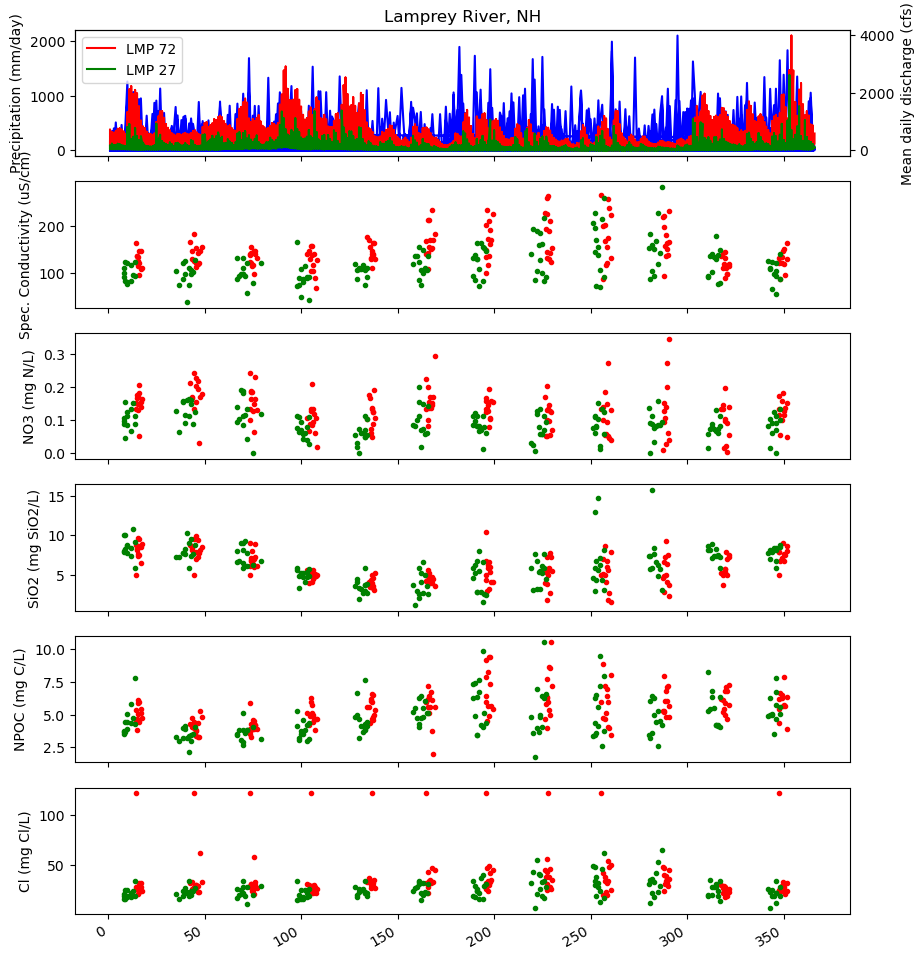

In [24]:
# Plot preliminary timeseries with solute data by day of year
data27.sort_values(by='DOY', inplace = True)
data72.sort_values(by='DOY', inplace = True)

fig_title = "Lamprey River, NH"

# Create plot to display precipitation data
fig, (ax1, ax2, ax4, ax5, ax6, ax7) = plt.subplots(6, figsize = (10,13), sharex = True)

# Plot precipitation data with discharge at each site
ax3 = ax1.twinx()
ax1.plot(data_p['DOY'], data_p['PRCP_MM'],  
        'b-', label = 'Precipitation')
ax3.plot(data72['DOY'], data72['Q_CFS'], 'r-', label = 'LMP 72')     
ax3.plot(data27['DOY'], data27['Q_CFS'], 'g-', label = 'LMP 27')   

ax2.plot(merged_72['DOY'], merged_72['Spec_Cond'], 'r.')
ax2.plot(merged_27['DOY'], merged_27['Spec_Cond'], 'g.')

ax4.plot(merged_72['DOY'], merged_72['NO3 (mg N/L)'], 'r.')
ax4.plot(merged_27['DOY'], merged_27['NO3 (mg N/L)'], 'g.')

ax5.plot(merged_72['DOY'], merged_72['SiO2 (mg SiO2/L)'], 'r.')
ax5.plot(merged_27['DOY'], merged_27['SiO2 (mg SiO2/L)'], 'g.')

ax6.plot(merged_72['DOY'], merged_72['NPOC (mg C/L)'], 'r.')
ax6.plot(merged_27['DOY'], merged_27['NPOC (mg C/L)'], 'g.')

ax7.plot(merged_72['DOY'], merged_72['Cl (mg Cl/L)'], 'r.')
ax7.plot(merged_27['DOY'], merged_27['Cl (mg Cl/L)'], 'g.')
                                    
# Add y-axis label    
ax1.set_ylabel('Precipitation (mm/day)')  
ax3.set_ylabel('Mean daily discharge (cfs)') 

ax2.set_ylabel('Spec. Conductivity (uS/cm)')
ax4.set_ylabel('NO3 (mg N/L)')
ax5.set_ylabel('SiO2 (mg SiO2/L)')
ax6.set_ylabel('NPOC (mg C/L)')
ax7.set_ylabel('Cl (mg Cl/L)')

# Add plot title
plt.title(fig_title)

leg = plt.legend()

# Optional command to make x-tick labels diagonal to avoid overlap
fig.autofmt_xdate()  

plt.show()

In [11]:
# Interpolate missing data
# necessary for lsqplot function
# Should eventually turn this into a function based on name of column

# LMP 72
merged_72['SiO2 (mg SiO2/L)'] = merged_72['SiO2 (mg SiO2/L)'].interpolate(method='time')
merged_72['NPOC (mg C/L)'] = merged_72['NPOC (mg C/L)'].interpolate(method='time')
merged_72['TDN (mg N/L)'] = merged_72['TDN (mg N/L)'].interpolate(method='time')
merged_72['Spec_Cond'] = merged_72['Spec_Cond'].interpolate(method='time')
merged_72['NO3 (mg N/L)'] = merged_72['NO3 (mg N/L)'].interpolate(method='time')
merged_72['Cl (mg Cl/L)'] = merged_72['Cl (mg Cl/L)'].interpolate(method='time')

# LMP 27
merged_27['SiO2 (mg SiO2/L)'] = merged_27['SiO2 (mg SiO2/L)'].interpolate(method='time')
merged_27['NPOC (mg C/L)'] = merged_27['NPOC (mg C/L)'].interpolate(method='time')
merged_27['TDN (mg N/L)'] = merged_27['TDN (mg N/L)'].interpolate(method='time')
merged_27['Spec_Cond'] = merged_27['Spec_Cond'].interpolate(method='time')
merged_27['NO3 (mg N/L)'] = merged_27['NO3 (mg N/L)'].interpolate(method='time')
merged_27['Cl (mg Cl/L)'] = merged_27['Cl (mg Cl/L)'].interpolate(method='time')

In [12]:
# Linear regression function


def lsqplot(x, y, nonparam=False, xlabel=None, ylabel=None, xtoplot=None, fig_title=None):
    """ Plot least-squares fit to data.

    Function to create scatter plot of x-y data, including regression
    line(s) and annotation with regression parameters and statistics.

    Parameters
    ----------
    x : array
        Independent 1-D numerical data; use "x = np.array(x value)"
    y : array
        Independent 1-D numerical data with the same length as x; use "x = np.array(x value)"    
    nonparam : boolean
        Toggle to determine whether to include non-parametric fit 
    xlabel : string
        Text to use as x-label on plot
    ylabel : string
        Text to use as y-label on plot
    xtoplot : array or series
        Alternative positions for x data to use in plotting not fitting;
        shuold be 1-D numerical or datetime data with same length as x
    fig_title : string
        Text to use as title of figure
    """

    lsq_coeff = stats.linregress(x, y)
    sen_coeff = stats.theilslopes(y, x, 0.95)
    tau = stats.kendalltau(x, y)

    if xtoplot is None:
        xtoplot = x


    fig, ax = plt.subplots()
    ax.plot(xtoplot, y, 'k.')
    ax.plot(xtoplot, lsq_coeff.intercept + lsq_coeff.slope *
            x, 'b-', label='Linear regression')
    
    y_buffer = (max(y) - min(y)) * 0.2
    ax.set_ylim(min(y) - y_buffer, max(y) + y_buffer)
    xx = ax.get_xlim()
    yy = ax.get_ylim()
    
    ax.annotate(f'Least-squares slope = {lsq_coeff.slope:.6f} +/- {2*lsq_coeff.stderr:.6f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.23*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares intercept = {lsq_coeff.intercept:.3f} +/- {2*lsq_coeff.intercept_stderr:.3f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.18*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares correlation = {lsq_coeff.rvalue:.3f}; p = {lsq_coeff.pvalue:.6f}',
                xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.13*(yy[1]-yy[0])),
                horizontalalignment='right')

    if nonparam is True:
        ax.plot(xtoplot, sen_coeff.intercept + sen_coeff.slope *
                x, 'r-', label='Theil-Sen regression')
        ax.annotate(f'Theil-Sen slope = {sen_coeff.slope:.4f} +/- {0.5*(sen_coeff.high_slope - sen_coeff.low_slope):.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                    horizontalalignment='right')
        ax.annotate(f'Theil-Sen intercept = {sen_coeff.intercept:.4f}',
                    xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                    horizontalalignment='right')
        ax.annotate(f'Tau correlation = {tau.correlation:.3f}; p = {tau.pvalue:.6f}',
            xy=(xx[1]-0.05*(xx[1]-xx[0]), yy[0] + 0.005*(yy[1]-yy[0])),
            horizontalalignment='right')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(fig_title)
    ax.legend()
    plt.show()
    
    # Return the least-squares regression result
    return lsq_coeff
  

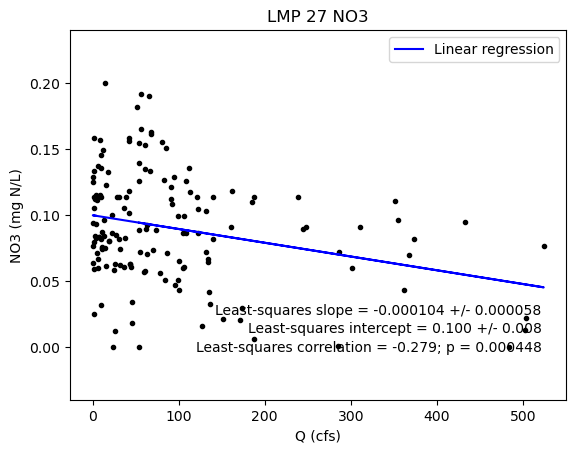

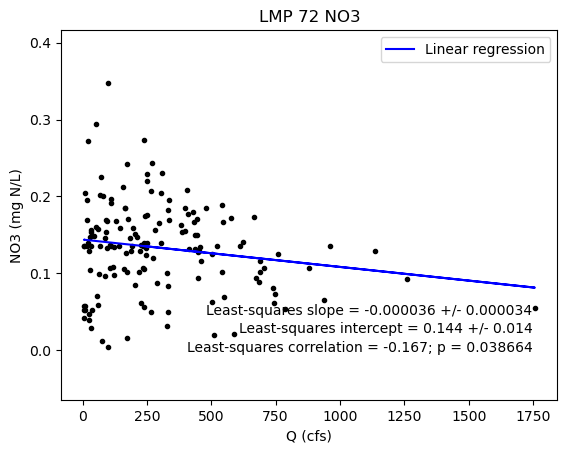

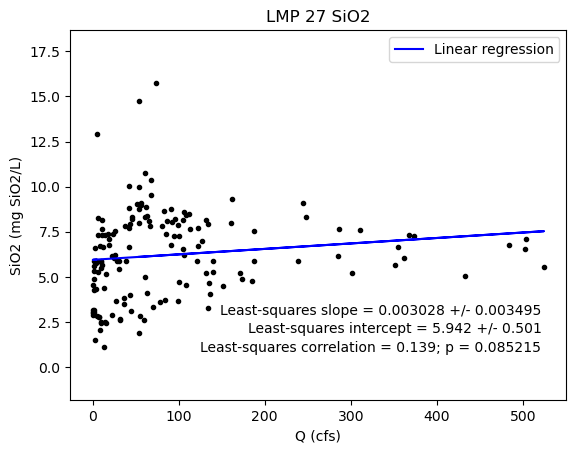

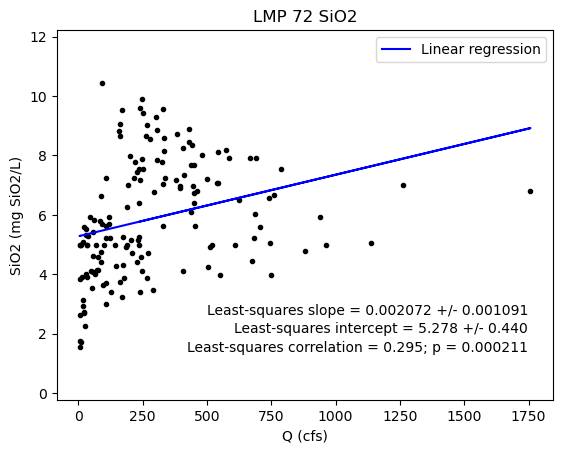

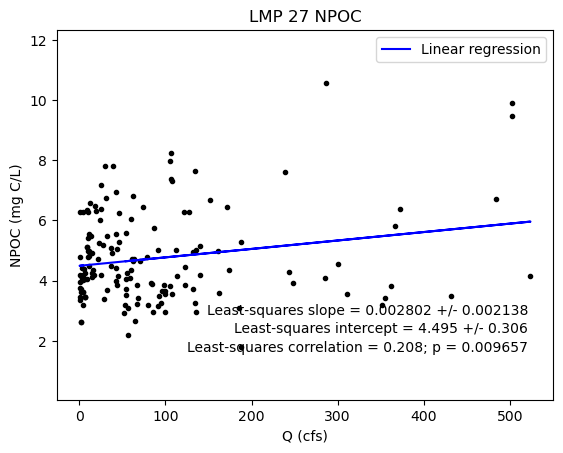

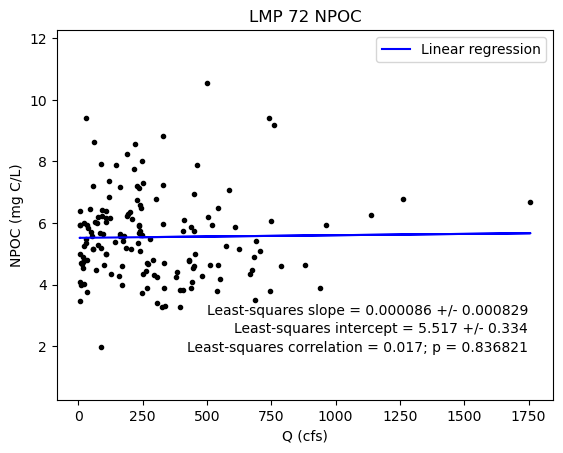

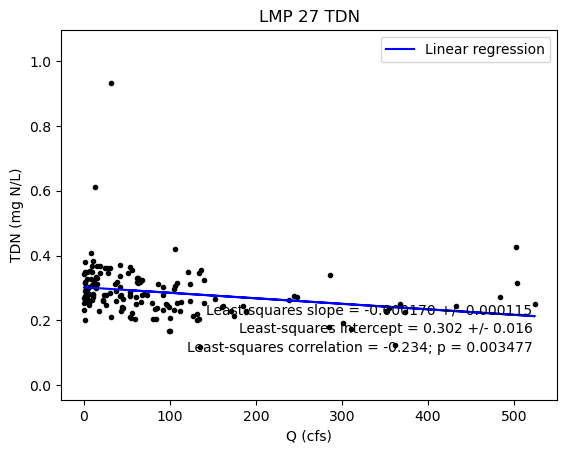

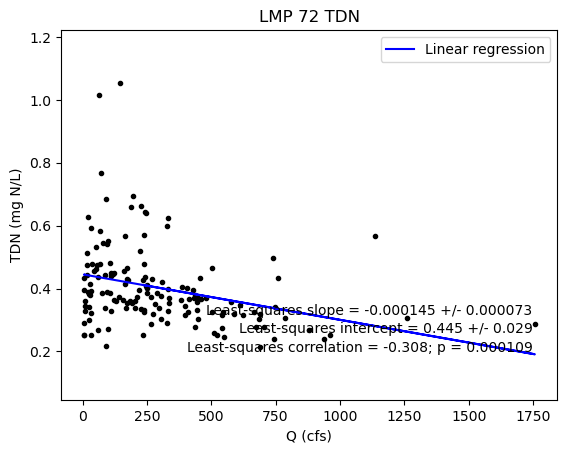

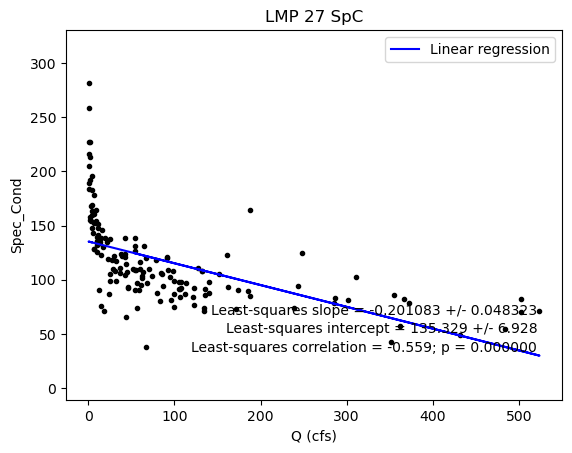

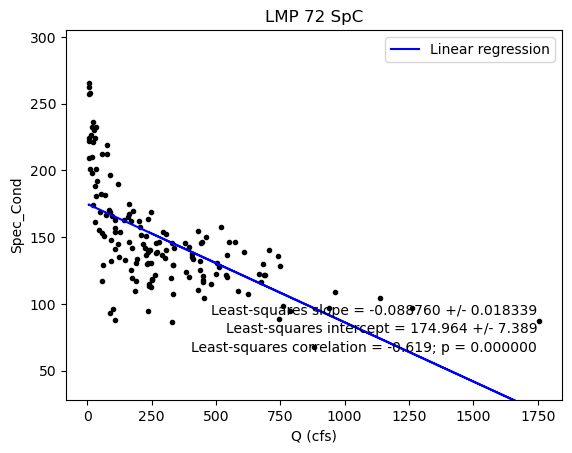

In [13]:
# Plot CQ of solutes between sites
## Nitrate
# LMP 27
nitrate27 = lsqplot(x=np.array(merged_27['Q_CFS']),
    y=np.array(merged_27['NO3 (mg N/L)']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'NO3 (mg N/L)',
    xtoplot=None,
    fig_title = 'LMP 27 NO3')

# LMP 72
nitrate72 = lsqplot(x=np.array(merged_72['Q_CFS']),
    y=np.array(merged_72['NO3 (mg N/L)']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'NO3 (mg N/L)',
    xtoplot=None,
    fig_title = 'LMP 72 NO3')

## SiO2
# LMP 27
silica27 = lsqplot(x=np.array(merged_27['Q_CFS']),
    y=np.array(merged_27['SiO2 (mg SiO2/L)']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'SiO2 (mg SiO2/L)',
    xtoplot=None,
    fig_title = 'LMP 27 SiO2')

# LMP 72
silica72 = lsqplot(x=np.array(merged_72['Q_CFS']),
    y=np.array(merged_72['SiO2 (mg SiO2/L)']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'SiO2 (mg SiO2/L)',
    xtoplot=None,
    fig_title = 'LMP 72 SiO2')

## NPOC
# LMP 27
npoc27 = lsqplot(x=np.array(merged_27['Q_CFS']),
    y=np.array(merged_27['NPOC (mg C/L)']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'NPOC (mg C/L)',
    xtoplot=None,
    fig_title = 'LMP 27 NPOC')

# LMP 72
npoc72 = lsqplot(x=np.array(merged_72['Q_CFS']),
    y=np.array(merged_72['NPOC (mg C/L)']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'NPOC (mg C/L)',
    xtoplot=None,
    fig_title = 'LMP 72 NPOC')

## Spec Cond.
# LMP 27
speccond27 = lsqplot(x=np.array(merged_27['Q_CFS']),
    y=np.array(merged_27['Spec_Cond']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'Spec_Cond',
    xtoplot=None,
    fig_title = 'LMP 27 SpC')

# LMP 72
speccond72 = lsqplot(x=np.array(merged_72['Q_CFS']),
    y=np.array(merged_72['Spec_Cond']),
    nonparam =False,
    xlabel ='Q (cfs)',
    ylabel = 'Spec_Cond',
    xtoplot=None,
    fig_title = 'LMP 72 SpC')

In [16]:
# Calculate residuals for nitrate

merged_27['predicted'] = nitrate27.intercept + (nitrate27.slope * merged_27['Q_CFS'])
merged_27['residuals'] = merged_27['NO3 (mg N/L)'] - merged_27['predicted']

merged_72['predicted'] = nitrate72.intercept + (nitrate72.slope * merged_72['Q_CFS'])
merged_72['residuals'] = merged_72['NO3 (mg N/L)'] - merged_72['predicted']

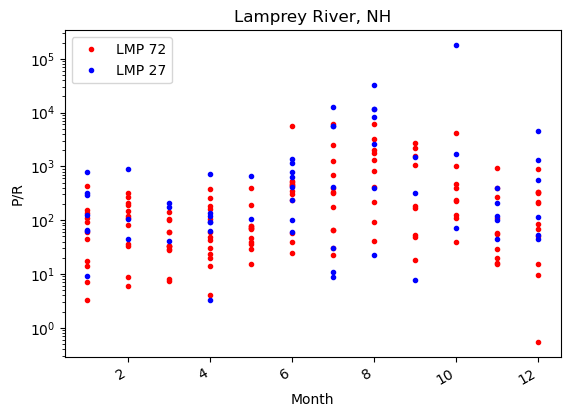

In [19]:
# Plotting P/R over time, by month
fig_title = "Lamprey River, NH"

# Create plot to display precipitation data
fig, ax = plt.subplots()

# Plot residuals v. P/R at each site
ax.plot(merged_72.index.month, merged_72['P/R'], 'r.', label = 'LMP 72')     
ax.plot(merged_27.index.month, merged_27['P/R'], 'b.', label = 'LMP 27')   
   
ax.set_yscale('log')                                 
# Add y-axis label    
ax.set_ylabel('P/R')  
ax.set_xlabel('Month') 

# Add plot title
plt.title(fig_title)

leg = plt.legend()

# Optional command to make x-tick labels diagonal to avoid overlap
fig.autofmt_xdate()  

plt.show()

In [20]:
# Calculating antecedent P/R

# Could turn this into a function probably #

# New column of 7 day averages of precipitation 
merged_72['P-1'] = merged_72['PRCP_MM'].rolling(7, center = False).mean()
merged_27['P-1'] = merged_27['PRCP_MM'].rolling(7, center = False).mean()
# is it the mean we want? yes I think so
# because our measurements of nitrate (other solutes) are not daily, would rolling window of 7 for 7 days make sense?

# (t-2 weeks would be 14 day averages, etc)
merged_72['P-2'] = merged_72['PRCP_MM'].rolling(14, center = False).mean()
merged_27['P-2'] = merged_27['PRCP_MM'].rolling(14, center = False).mean()

# t-3 weeks
merged_72['P-3'] = merged_72['PRCP_MM'].rolling(21, center = False).mean()
merged_27['P-3'] = merged_27['PRCP_MM'].rolling(21, center = False).mean()

# t-4 weeks
merged_72['P-4'] = merged_72['PRCP_MM'].rolling(28, center = False).mean()
merged_27['P-4'] = merged_27['PRCP_MM'].rolling(28, center = False).mean()

# t -10 weeks
merged_72['P-10'] = merged_72['PRCP_MM'].rolling(70, center = False).mean()
merged_27['P-10'] = merged_27['PRCP_MM'].rolling(70, center = False).mean()

# New column of precip averages/runoff
merged_72['P-1/R'] = merged_72['P-1']/merged_72['runoff_MM']
merged_27['P-1/R'] = merged_27['P-1']/merged_27['runoff_MM']

merged_72['P-2/R'] = merged_72['P-2']/merged_72['runoff_MM']
merged_27['P-2/R'] = merged_27['P-2']/merged_27['runoff_MM']

merged_72['P-3/R'] = merged_72['P-3']/merged_72['runoff_MM']
merged_27['P-3/R'] = merged_27['P-3']/merged_27['runoff_MM']

merged_72['P-4/R'] = merged_72['P-4']/merged_72['runoff_MM']
merged_27['P-4/R'] = merged_27['P-4']/merged_27['runoff_MM']

merged_72['P-10/R'] = merged_72['P-10']/merged_72['runoff_MM']
merged_27['P-10/R'] = merged_27['P-10']/merged_27['runoff_MM']

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


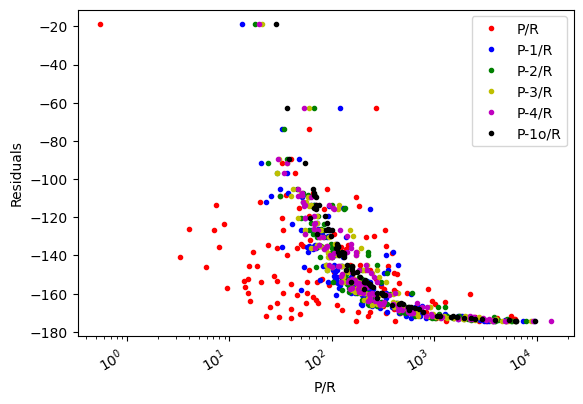

In [25]:
# Plotting antecedent P/R LMP 72

# Create plot to display precipitation data
fig, ax = plt.subplots()

# Plot residuals v. P/R at each site
ax.plot(merged_72['P/R'], merged_72['residuals'], 'r.', label = 'P/R')     
ax.plot(merged_72['P-1/R'], merged_72['residuals'], 'b.', label = 'P-1/R') 
ax.plot(merged_72['P-2/R'], merged_72['residuals'], 'g.', label = 'P-2/R') 
ax.plot(merged_72['P-3/R'], merged_72['residuals'], 'y.', label = 'P-3/R') 
ax.plot(merged_72['P-4/R'], merged_72['residuals'], 'm.', label = 'P-4/R') 
ax.plot(merged_72['P-10/R'], merged_72['residuals'], 'k.', label = 'P-1o/R') 
        
ax.set_xscale('log')                            
# Add y-axis label    
ax.set_xlabel('P/R')  
ax.set_ylabel('Residuals') 


leg = plt.legend()

# Optional command to make x-tick labels diagonal to avoid overlap
fig.autofmt_xdate()  

plt.show()


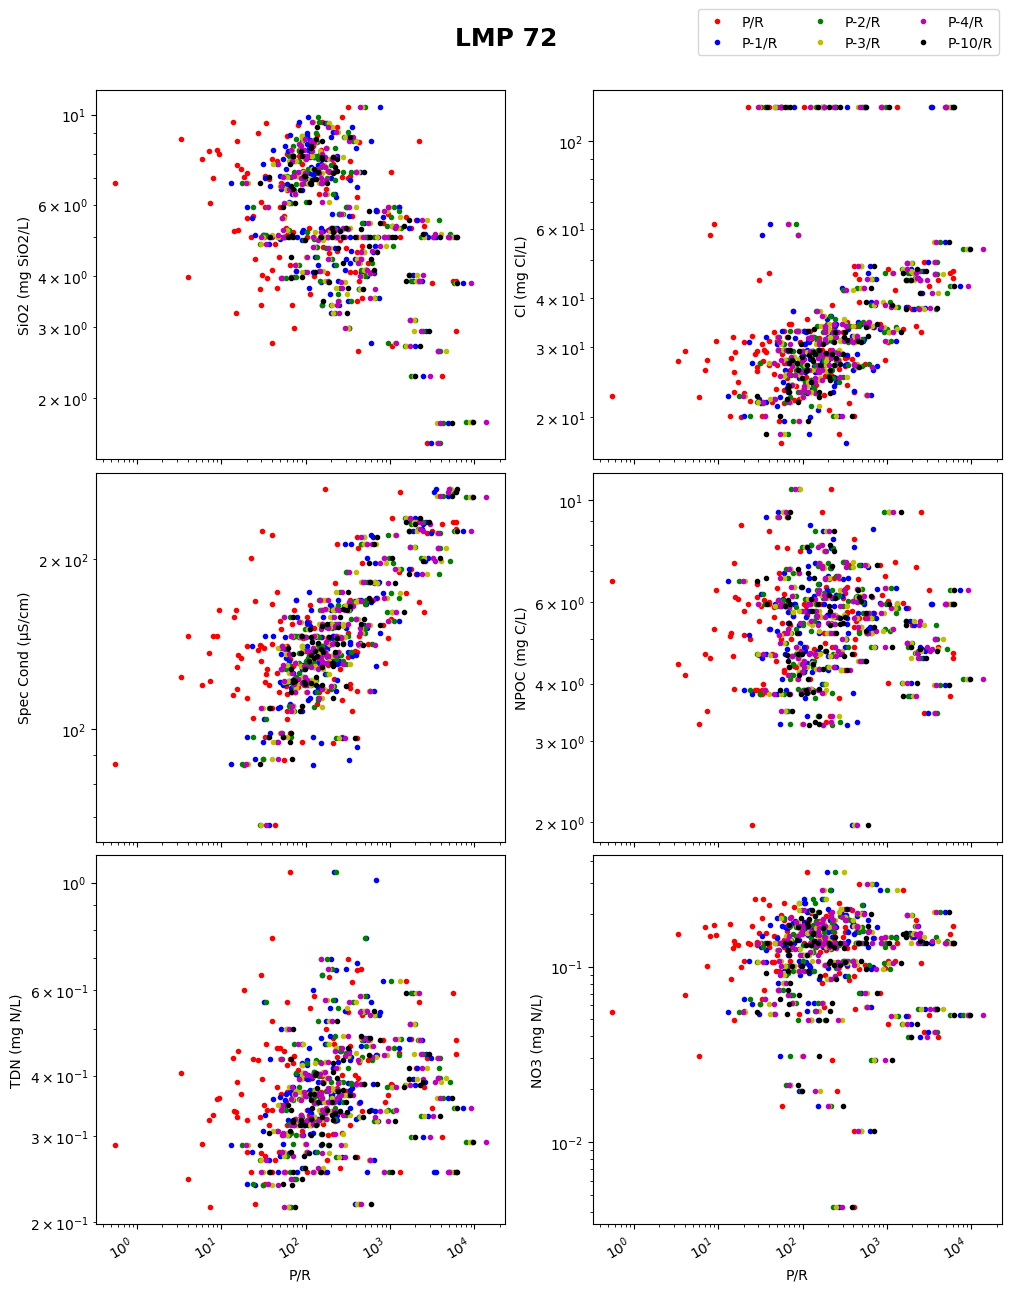

In [22]:
# Plotting analytes with P/R itself (LMP 72)

# Create a 2-column x 3-row grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), layout="constrained")

# Flatten the 2D array of axes for easy indexing
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# Define analytes and labels
plots = [
    ("SiO2 (mg SiO2/L)", "SiO2 (mg SiO2/L)"),
    ("Cl (mg Cl/L)", "Cl (mg Cl/L)"),
    ("Spec_Cond", "Spec Cond (µS/cm)"),
    ("NPOC (mg C/L)", "NPOC (mg C/L)"),
    ("TDN (mg N/L)", "TDN (mg N/L)"),
    ("NO3 (mg N/L)", "NO3 (mg N/L)")
]

# List of colors and labels for the P/R variants
pr_cols = ["P/R", "P-1/R", "P-2/R", "P-3/R", "P-4/R", "P-10/R"]
colors = ["r", "b", "g", "y", "m", "k"]

label_size = 20
tick_size = 12
title_size = 18
legend_size = 12

# Loop over each subplot
for ax, (col, ylabel) in zip([ax1, ax2, ax3, ax4, ax5, ax6], plots):
    for c, p in zip(colors, pr_cols):
        ax.plot(merged_72[p], merged_72[col], f"{c}.", label=p)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P/R")
    ax.set_ylabel(ylabel)

# Add one shared legend for all axes
fig.legend(pr_cols, loc='upper right', ncol=3, bbox_to_anchor=(1, 1.07))

fig.suptitle("LMP 72", fontsize=title_size, fontweight='bold', y=1.05)

# Rotate tick labels for readability
fig.autofmt_xdate()

plt.show()

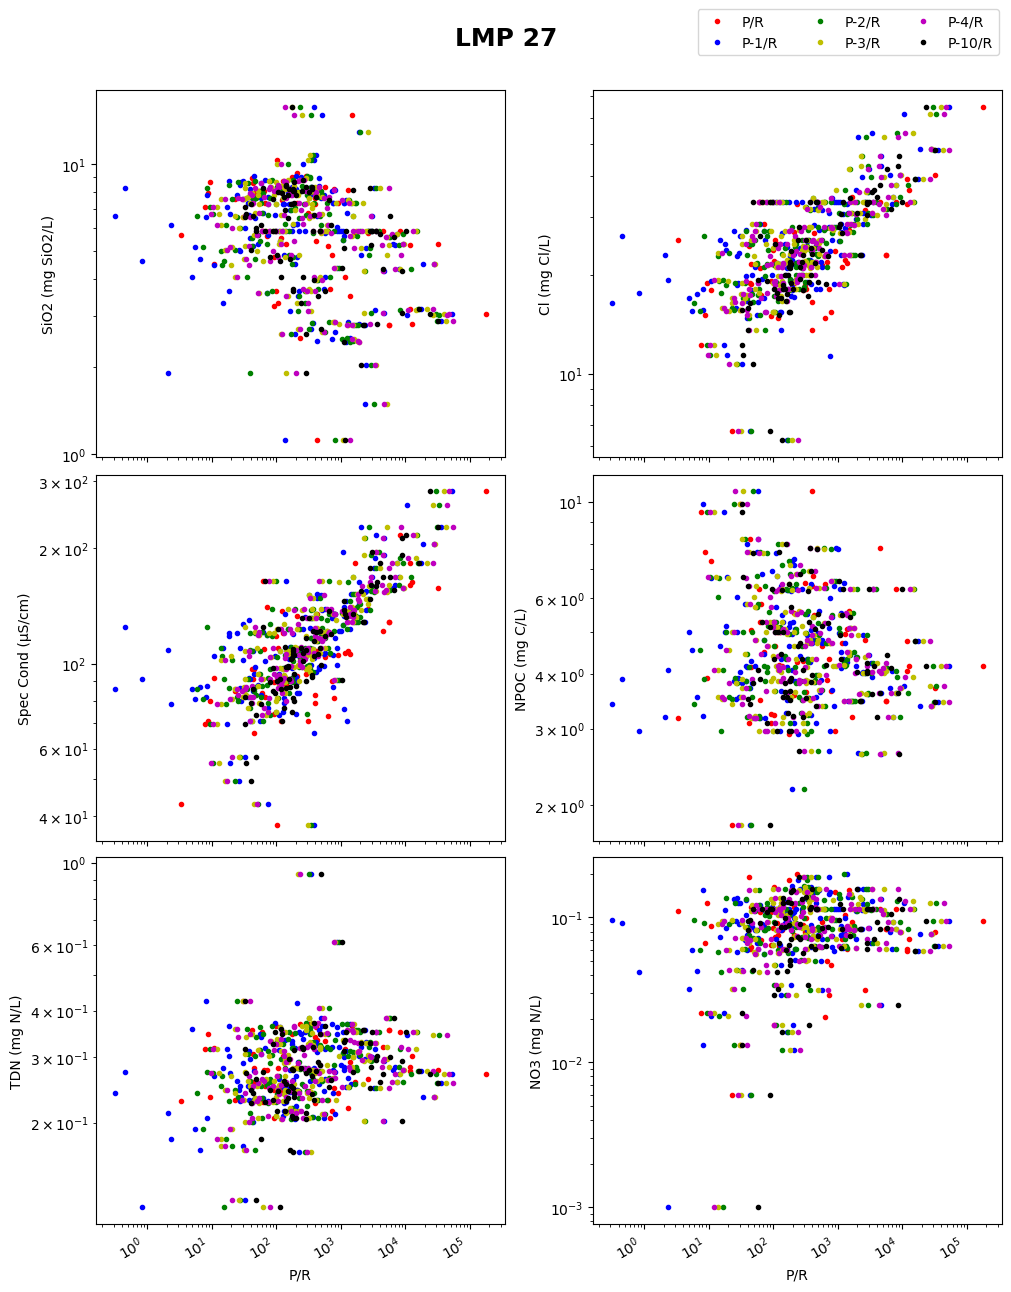

In [23]:
# Plotting analytes with P/R itself (LMP 27)

# Create a 2-column x 3-row grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), layout="constrained")

# Flatten the 2D array of axes for easy indexing
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# Define analytes and labels
plots = [
    ("SiO2 (mg SiO2/L)", "SiO2 (mg SiO2/L)"),
    ("Cl (mg Cl/L)", "Cl (mg Cl/L)"),
    ("Spec_Cond", "Spec Cond (µS/cm)"),
    ("NPOC (mg C/L)", "NPOC (mg C/L)"),
    ("TDN (mg N/L)", "TDN (mg N/L)"),
    ("NO3 (mg N/L)", "NO3 (mg N/L)")
]

# List of colors and labels for the P/R variants
pr_cols = ["P/R", "P-1/R", "P-2/R", "P-3/R", "P-4/R", "P-10/R"]
colors = ["r", "b", "g", "y", "m", "k"]

label_size = 20
tick_size = 12
title_size = 18
legend_size = 12

# Loop over each subplot
for ax, (col, ylabel) in zip([ax1, ax2, ax3, ax4, ax5, ax6], plots):
    for c, p in zip(colors, pr_cols):
        ax.plot(merged_27[p], merged_27[col], f"{c}.", label=p)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P/R")
    ax.set_ylabel(ylabel)

# Add one shared legend for all axes
fig.legend(pr_cols, loc='upper right', ncol=3, bbox_to_anchor=(1, 1.07))

fig.suptitle("LMP 27", fontsize=title_size, fontweight='bold', y=1.05)


# Rotate tick labels for readability
fig.autofmt_xdate()

plt.show()

In [ ]:
# Power law function
# Function where I can apply a power law function and best fit line with statistics to each array and plot them all together

In [1]:
# CQ slopes of each year
